In [1]:
# εγκατάσταση απαραίτητων πακέτων
using Pkg
Pkg.add(["Plots", "StatsBase"])

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/workspace/Thesis/Project.toml`
 [no changes]
   Updating `~/workspace/Thesis/Manifest.toml`
 [no changes]


# Πεπερασμένες Διαφορές σε Μερικές Διαφορικές Εξισώσεις

In [6]:
using Plots, StatsBase

In [2]:
function sine_finite_diff(L, nx, λ)
    #= πρώτα υπολογίζουμε το dx, υπάρχουν nx σημεία στον χώρο
    άρα υπάρχουν nx - 1 διαστήματα dx, διαιρούμε το L διά
    τον αριθμό τους για να βρούμε το μήκος τους =#
    dx = L / (nx - 1)
    X = collect(range(0, L, length = nx))
    #= το λ είναι ένας ακέραιος αριθμός που εκφράζει το μήκος
    του κύματος σε μονάδες dx, δηλαδή εάν έχουμε σαν είσοδο
    λ = 25, τότε πολλαπλασιάζουμε επί dx ώστε το μήκος του
    κύματος να είναι 25dx =#
    λ *= dx
    #= το k εμπεριέχει το 2π το οποίο θα μετατρέψει τους
    αριθμούς του X σε ακτίνια και το 1 / λ το οποίο αναπαριστά
    την συχνότητα του κύματος. Θυμηθείτε ότι
    συχνότητα = 1 / περίοδο =#
    k = 2pi / λ
    #= εφαρμόζουμε την συνάρτηση του ημιτόνου ώστε να
    δημιουργήσουμε διακριτό ημιτονοειδές κύμα =#
    F = sin.(k * X)
    #= υπολογίζουμε την αναλυτική παράγωγο, θυμηθείτε ότι
    sin(kx)' = kcos(kx) =#
    ad = k * cos.(k * X)
    #= δημιουργούμε άδειο πίνακα μηδενικών μήκους nx στον
    οποίο θα βάλουμε τα αποτελέσματα =#
    nd = zeros(nx)
    #= για κάθε τιμή του κύματος εφαρμόζουμε την
    Κεντρική Πεπερασμένη Διαφορά=#
    for i in 2:nx-1
        nd[i] = (F[i+1] - F[i-1]) / 2dx
    end
    #= υπολογίζουμε το Root Mean Squared Error ώστε να
    αξιολογήσουμε το σφάλμα της προσέγγισης σε σχέση με
    την πραγματική παράγωγο =#
    rmse = ad[2:end-1] - nd[2:end-1] .|> (x->x^2) |> mean |> sqrt
    #= επιστρέφουμε πλειάδα τεσσάρων στοιχείων που περιέχει
    τα στοιχεία του άξονα X, τον πίνακα με την αναλυτική παράγωγο,
    τον πίνακα με την αριθμητική παράγωγο και το rmse =#
    (X, ad, nd, rmse)
end

sine_finite_diff (generic function with 1 method)

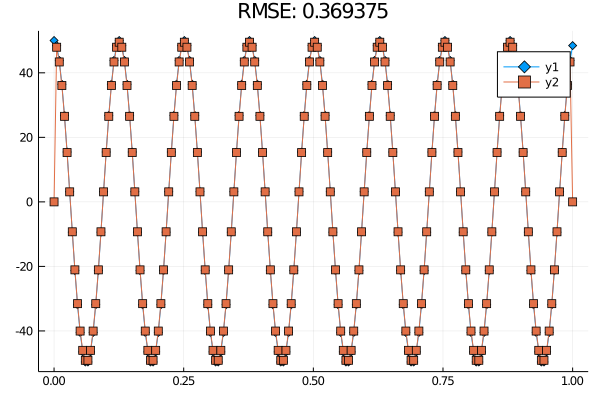

In [7]:
let L = 1, nx = 200, λ = 25
    (X, ad, nd, rmse) = sine_finite_diff(L, nx, λ)
    plot(X, [ad nd], marker = [:diamond :square], title = "RMSE: $(round(rmse, digits = 6))")
end

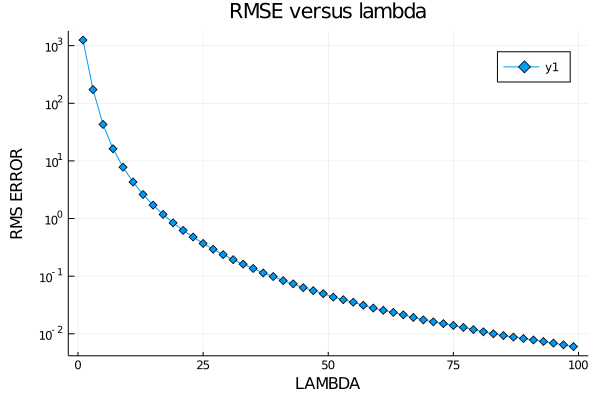

In [11]:
let L = 1, nx = 200, λ = 1:2:100
    tuples = sine_finite_diff.(L, nx, λ)
    errs = last.(tuples)
    plot(λ, errs, mark = :diamond, title = "RMSE versus lambda", yaxis = :log, xlabel = "LAMBDA", ylabel = "RMS ERROR")
end

# Αριθμιτική Επίλυση της Εξίσωσης Θερμότητας

In [12]:
function heat_equation_rod(L, nx, nt, σ, α, bcs)
    #= πρώτα υπολογίζουμε το dx, υπάρχουν nx σημεία στον χώρο=#
    #= υπολογίζουμε το dx όπως και στο παράδειγμα με την
    ημιτονοειδή συνάρτηση =#
    dx = L / (nx - 1)
    # παράγουμε πίνακα με τα σημεία του άξονα Χ
    X = collect(range(0, L, length = nx))
    #= ο τρόπος υπολογισμού του dt περιγράφεται αναλυτικά στο
    κείμενο =#
    dt = σ * (dx ^ 2) / α
    #= οριακές συνθήκες για την ράβδο, θερμοκρασία στο αριστερό
    και το δεξί μέρος =#
    (bc_left, bc_right) = bcs
    #= πίνακας μηδενικών που θα αποθηκευτούν τα αποτελέσματα,
    θα έχουμε nt χρονικές στιγμές - γραμμές και nx διακριτά σημεία
    πάνω στην ράβδο =#
    u = zeros(nt, nx)
    # θέτουμε τις οριακές συνθήκες για κάθε χρονική στιγμή
    u[:, 1] .= bc_left
    u[:, end] .= bc_right
    #= για κάθε χρονική στιγμή εκτός από την πρώτη (καθώς η πρώτη
    περιέχει τις αρχικές συνθήκες του προβλήματος) και για κάθε
    σημείο της ράβδου εκτος από τις άκρες (καθώς οι άκρες
    περιέχουν τις οριακές συνθήκες) εφάρμοσε την εξίσωση
    διάχυσης θερμότητας για το σημείο j την επόμενη χρονική στιμή
    n+1 =#
    for n = 1:nt-1
        for j = 2:nx-1
            u[n+1, j] = α * dt / dx^2 * (u[n, j+1] - 2u[n, j] +
            u[n, j-1]) + u[n, j]
        end
    end
    # επιστρέφουμε τον πίνακα με τα αποτελέσματα
    u
end

heat_equation_rod (generic function with 1 method)

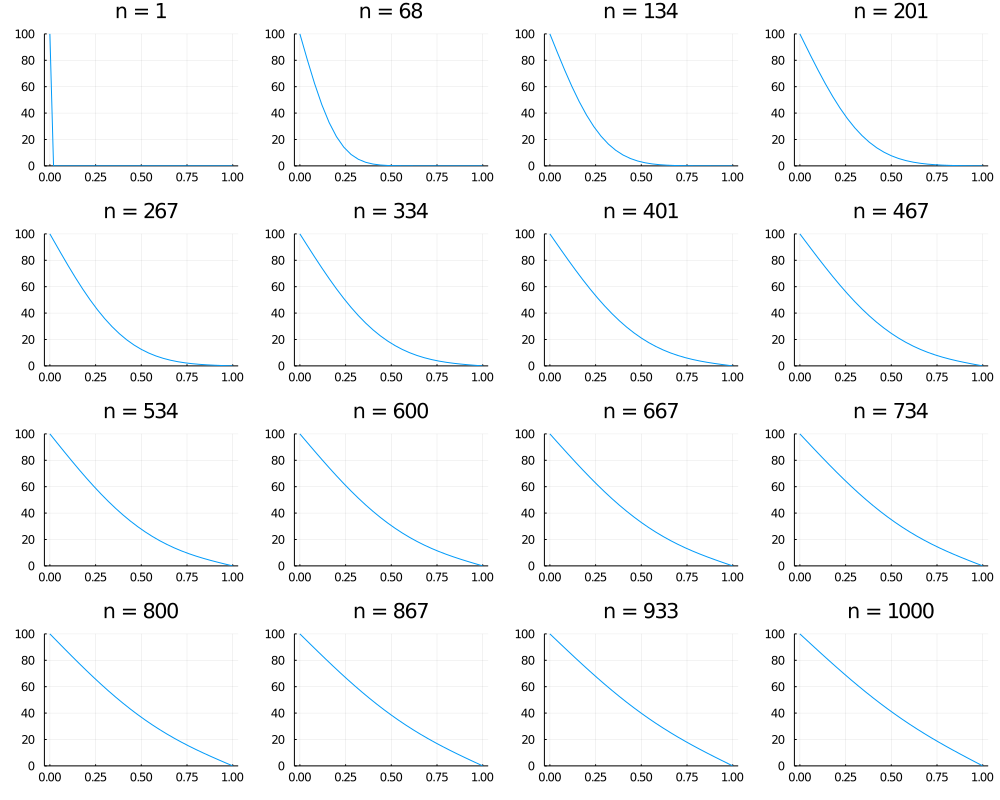

In [22]:
let L = 1, nx = 51, nt = 1000, σ = 0.5, α = 1.22e-3, bcs = (100, 0)
    u = heat_equation_rod(L, nx, nt, σ, α, bcs)
    X = collect(range(0, L, length = nx))
    plots = []
    for n in range(1, nt, length = 16)
        n = round(Int64, n)
        push!(plots, plot(X, u[n,:], ylims = reverse(bcs), title = "n = $n", lab = :false))
    end
    plot(plots..., layout = (4, 4), size = (1000, 800))
end

┌ Info: Saved animation to 
│   fn = /Users/spiros/workspace/Thesis/textbook-companion/tmp.gif
└ @ Plots /Users/spiros/.julia/packages/Plots/8GUYs/src/animation.jl:102


Plots.AnimatedGif("/Users/spiros/workspace/Thesis/textbook-companion/tmp.gif")
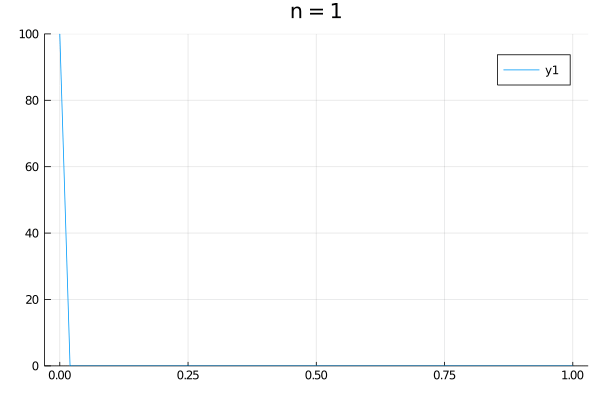

In [24]:
let L = 1, nx = 51, nt = 1000, σ = 0.5, α = 1.22e-3, bcs = (100, 0)
    u = heat_equation_rod(L, nx, nt, σ, α, bcs)
    X = collect(range(0, L, length = nx))
    @gif for n = 1:nt
        plot(X, u[n, :], ylim = reverse(bcs), title = "n = $n")
    end
end